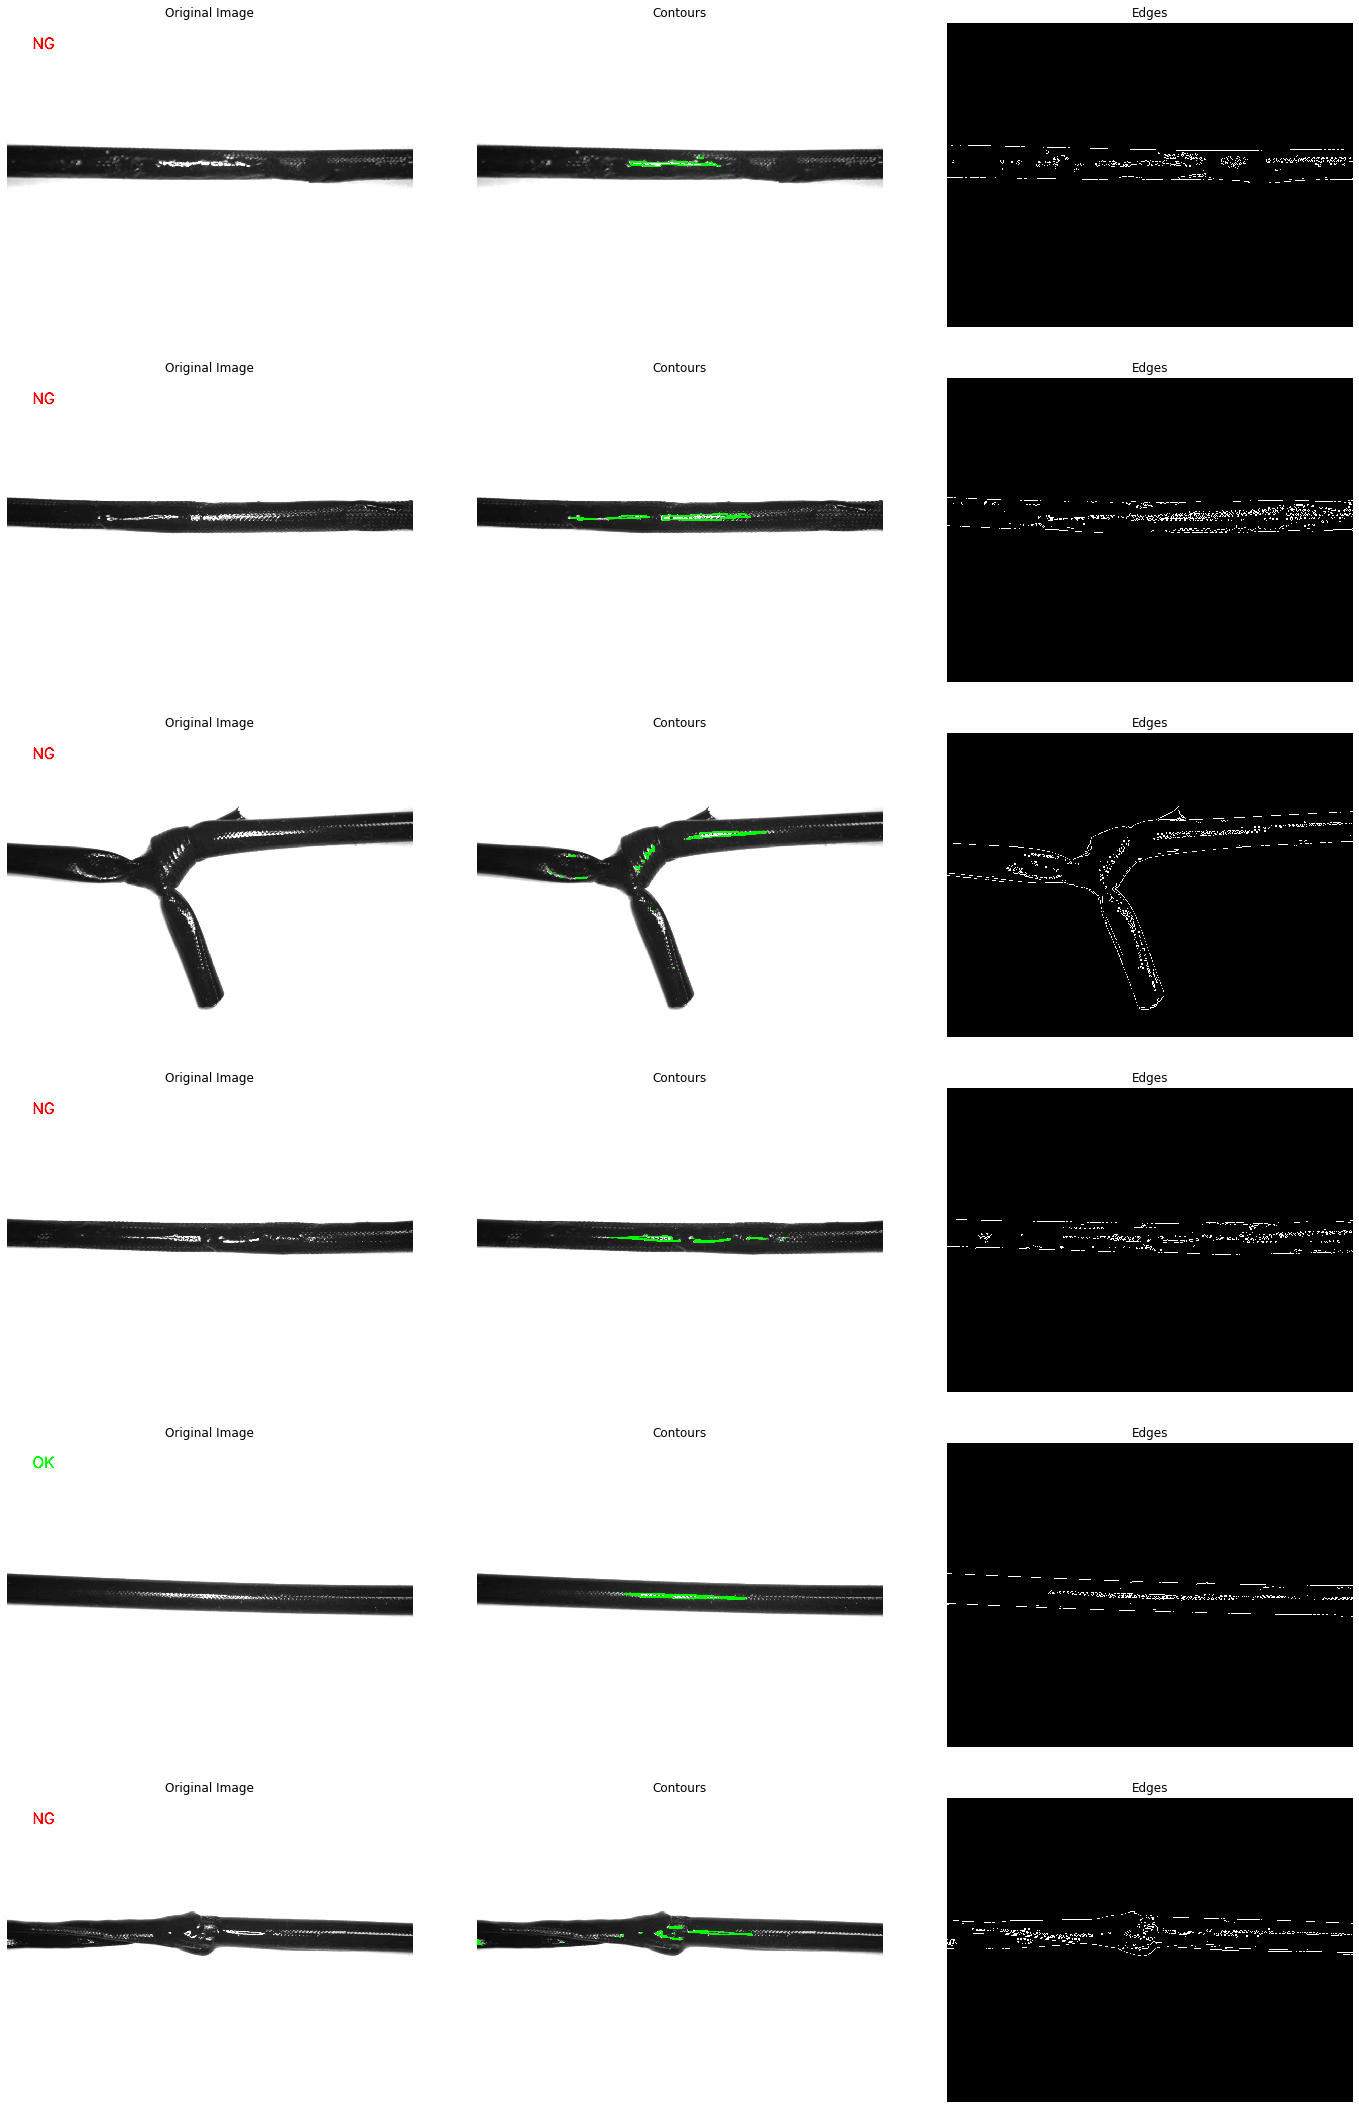

In [84]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 列出 'images' 目录中的所有图片
images_directory = 'images'
image_files = [f for f in os.listdir(images_directory) if os.path.isfile(os.path.join(images_directory, f))]

# 定义一个函数来处理单个图像
def process_image(image_path):
    ############################################
    # 读取图像，并转化成灰度图
    ############################################
    # 读取图像
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Error loading image {image_path}")
        return None
    # 转换颜色空间到灰度
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ############################################
    # 斑点检测
    ############################################
    # 应用阈值
    _, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    # 使用形态学操作去噪和连接斑点
    kernel = np.ones((3,8),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=3)
    # 确定斑点位置
    contours, _ = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # 设置面积阈值
    area_threshold = 5000  # 根据需要调整这个值
    # 过滤面积大于阈值的斑点
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) < area_threshold]
    # 在原图上绘制过滤后的斑点位置
    contour_image = image.copy()
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)

    ############################################
    # 直线检测
    ############################################
    # 使用Canny边缘检测
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    # 使用霍夫变换检测直线
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
    # 判断直线数量和形状
    if lines is not None:
        # 假设两条直线都应该是垂直或水平的
        angles = []
        for line in lines:
            x1, y1, x2, y2 = line[0]
            angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
            angles.append(angle)
        # 判断角度是否接近垂直或水平 判断斑点个数是否小于等于2
        if all(abs(angle) < 5 or abs(angle - 90) < 5 for angle in angles) and (len(filtered_contours) <= 2):
            # 在图像上标注“合格”
            cv2.putText(image, 'OK', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        else:
            # 在图像上标注“不合格”
            cv2.putText(image, 'NG', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    else:
        # 如果不是两条直线，标注“不合格”
        cv2.putText(image, 'NG', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
    # 转换颜色空间到RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, contour_image, edges

# 创建子图网格
fig, axs = plt.subplots(len(image_files), 3, figsize=(20, 5 * len(image_files)))
fig.tight_layout(pad=3.0)

# 遍历所有图片并处理
for i, image_file in enumerate(image_files):
    image_path = os.path.join(images_directory, image_file)
    processed_images = process_image(image_path)
    if processed_images is not None:
        original, contours, edges = processed_images
        axs[i, 0].imshow(original)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(contours)
        axs[i, 1].set_title('Contours')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(edges, cmap='gray')
        axs[i, 2].set_title('Edges')
        axs[i, 2].axis('off')